This notebook is used to test the `cartan_plugin.py` file and to make sure the plugin is installed correctly.

In [170]:
# Import the `cartan_plugin.py` file.
from qiskit_cartan.cartan_plugin import *

# Enable transpiler logging.
import logging
# logging.basicConfig(level='DEBUG')
logging.basicConfig()

#### Check `synth_cartan` works as intended with an example 3q NNN-open Heisenberg Hamiltonian with uniform coefficients (all equal to 1) and an evolution time of `t=3`. In the 3q case this is equivalent to an NN-open Ham.

In [171]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp

# Create a SparsePauliOp representation of the Hamiltonian to be rested.
test_heisenberg_ham = SparsePauliOp(["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"], 
                                    coeffs = np.ones(6, dtype=int))

# Time to evolve the Hamiltonian for.
test_time_evolve = 3

# Create the corresponding PauliEvolutionGate instance.
test_paulievolutiongate = PauliEvolutionGate(test_heisenberg_ham, time=test_time_evolve)

# Test the high level synthesis works as intended.
qc = synth_cartan(paulievolutiongate=test_paulievolutiongate, random_seed=1)
print(qc)

Optimization terminated successfully.
         Current function value: -0.271988
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
--- 0.033226966857910156 seconds ---
Optimization Error:
1.568316222819728e-10
     ┌────────────────────────┐┌─────────────────────────┐»
q_0: ┤0                       ├┤0                        ├»
     │                        ││                         │»
q_1: ┤1 exp(-it XZY)(0.23183) ├┤1 exp(-it ZXY)(-0.23183) ├»
     │                        ││                         │»
q_2: ┤2                       ├┤2                        ├»
     └────────────────────────┘└─────────────────────────┘»
«     ┌─────────────────────────┐┌────────────────────────┐»
«q_0: ┤0                        ├┤0                       ├»
«     │                         ││                        │»
«q_1: ┤1 exp(-it YXZ)(-0.21027) ├┤1 exp(-it YZX)(0.21027) ├»
«     │                         ││                        │»
«q_2: ┤2                

In [172]:
from qiskit import Aer, transpile

# Retrieve the matrix corresponding to the original, un-decomposed circuit
# by running it on a Qiskit unitary_simulator.
unitary_simulator = Aer.get_backend('unitary_simulator')
qc_transp = transpile(qc, unitary_simulator)
final_unitary_cartan = unitary_simulator.run(qc_transp).result().get_unitary()

import scipy
from qiskit.quantum_info import SparsePauliOp

test_heisenberg_ham_matrix = test_heisenberg_ham.to_matrix()
propagator = scipy.linalg.expm(-1j*test_heisenberg_ham_matrix*test_time_evolve)
matrix_norm = np.linalg.norm(propagator - final_unitary_cartan)
print("\n")
print("matrix norm of the difference between the ideal propagator and that obtained by cartan decomposition: \n", matrix_norm)



matrix norm of the difference between the ideal propagator and that obtained by cartan decomposition: 
 4.939392876340576e-06


#### Check the HLS plugin is installed by inspecting a HighLevelSynthesisPluginManager instance.

In [173]:
from qiskit.transpiler.passes.synthesis.plugin import HighLevelSynthesisPluginManager
HLS_plugin_manager = HighLevelSynthesisPluginManager()
print(HLS_plugin_manager.plugins.names())

['PauliEvolution.cartan', 'clifford.default', 'linear_function.default', 'permutation.acg', 'permutation.basic', 'permutation.default', 'permutation.kms']


#### Test the plugin by creating an empty PassManager and only using a HLS Config corresponding to our HLS pass.

In [174]:
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))
print("before: ")
qc_before.draw()

before: 


┌──────────────────────────────────────────────────┐
q_0: ┤0                                                 ├
     │                                                  │
q_1: ┤1 exp(-it (XXI + YYI + ZZI + IXX + IYY + IZZ))(3) ├
     │                                                  │
q_2: ┤2                                                 ├
     └──────────────────────────────────────────────────┘

In [175]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis

hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":1})])
pm = PassManager()
pm.append(HighLevelSynthesis(hls_config=hls_config))
qc_after = pm.run(qc_before)
qc_after.draw()

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -0.271988
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
--- 0.03222179412841797 seconds ---
Optimization Error:
1.568316222819728e-10


┌────────────────────────┐┌─────────────────────────┐»
q_0: ┤0                       ├┤0                        ├»
     │                        ││                         │»
q_1: ┤1 exp(-it XZY)(0.23183) ├┤1 exp(-it ZXY)(-0.23183) ├»
     │                        ││                         │»
q_2: ┤2                       ├┤2                        ├»
     └────────────────────────┘└─────────────────────────┘»
«     ┌─────────────────────────┐┌────────────────────────┐»
«q_0: ┤0                        ├┤0                       ├»
«     │                         ││                        │»
«q_1: ┤1 exp(-it YXZ)(-0.21027) ├┤1 exp(-it YZX)(0.21027) ├»
«     │                         ││                        │»
«q_2: ┤2                        ├┤2                       ├»
«     └─────────────────────────┘└────────────────────────┘»
«     ┌────────────────────────┐┌─────────────────────────┐ ░ »
«q_0: ┤0                       ├┤0                        ├─░─»
«     │                        ││                         │ ░ »
«q_1: ┤1 exp(-it XYZ)(0.34236) ├┤1 exp(-it ZYX)(-0.34236) ├─░─»
«     │                        ││                         │ ░ »
«q_2: ┤2                       ├┤2                        ├─░─»
«     └────────────────────────┘└─────────────────────────┘ ░ »
«     ┌───────────────────┐┌──────────────────┐┌──────────────────┐ ░ »
«q_0: ┤0                  ├┤0                 ├┤0                 ├─░─»
«     │                   ││                  ││                  │ ░ »
«q_1: ┤1 exp(-it YIY)(-3) ├┤1 exp(-it IYY)(6) ├┤1 exp(-it YYI)(3) ├─░─»
«     │                   ││                  ││                  │ ░ »
«q_2: ┤2                  ├┤2                 ├┤2                 ├─░─»
«     └───────────────────┘└──────────────────┘└──────────────────┘ ░ »
«     ┌────────────────────────┐┌─────────────────────────┐»
«q_0: ┤0                       ├┤0                        ├»
«     │                        ││                         │»
«q_1: ┤1 exp(-it ZYX)(0.34236) ├┤1 exp(-it XYZ)(-0.34236) ├»
«     │                        ││                         │»
«q_2: ┤2                       ├┤2                        ├»
«     └────────────────────────┘└─────────────────────────┘»
«     ┌─────────────────────────┐┌────────────────────────┐»
«q_0: ┤0                        ├┤0                       ├»
«     │                         ││                        │»
«q_1: ┤1 exp(-it YZX)(-0.21027) ├┤1 exp(-it YXZ)(0.21027) ├»
«     │                         ││                        │»
«q_2: ┤2                        ├┤2                       ├»
«     └─────────────────────────┘└────────────────────────┘»
«     ┌────────────────────────┐┌─────────────────────────┐
«q_0: ┤0                       ├┤0                        ├
«     │                        ││                         │
«q_1: ┤1 exp(-it ZXY)(0.23183) ├┤1 exp(-it XZY)(-0.23183) ├
«     │                        ││                         │
«q_2: ┤2                       ├┤2                        ├
«     └────────────────────────┘└─────────────────────────┘

#### 3q NNN-open Heisenberg Ham on 3q linear backend

Generate many circuits, each corresponding to a random ordering of factors in K. Then feed each of the circuits above into a preset pass manager (the default pass managers used by the transpile() function) and get #CX gates. Then compare distribution of #CX with that resulting from a lexicographic ordering of factors in K.

In [176]:
# Specify number of circuits to generate.
size = 10

# Specify Ham and corresponding undecomposed circuit.
test_heisenberg_ham = SparsePauliOp(["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"], 
                                    coeffs = np.ones(6, dtype=int))
test_paulievolutiongate = PauliEvolutionGate(test_heisenberg_ham, time=test_time_evolve)
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))

# Create a PassManager objects containing the rest
# of the transpilation options.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import CouplingMap

pm_other = generate_preset_pass_manager(optimization_level=2, 
                                        layout_method="trivial",
                                        coupling_map=CouplingMap([[0, 1], [1, 0], [1, 2], [2, 1]]), 
                                        routing_method="sabre",
                                        translation_method="unroller",
                                        basis_gates="['u1', 'u2', 'u3', 'cx']",
                                        seed_transpiler=1)

# Generate transpiled circuits.
qc_list = []
different_seeds = random.sample(range(1, 101), size) # WLOG choose to generate random numbers between 1 and 100
for i in range(size):
    
    # Create a PassManager object containing just the custom HLS pass.
    hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":different_seeds[i]})])
    pm_hls = PassManager()
    pm_hls.append(HighLevelSynthesis(hls_config=hls_config))

    # First PassManager.
    qc_hls = pm_hls.run(qc_before) # HLS

    # Second PassManager.
    qc_l = pm_other.layout.run(qc_hls) # map virtual to physical
    qc_r = pm_other.routing.run(qc_l) # SABRE
    qc_t = pm_other.translation.run(qc_r) # unroller
    qc_o = pm_other.optimization.run(qc_t) # optimization

    qc_list.append(qc_o)

# Get CX distribution
num_cx_list = [qc.count_ops()['cx'] for qc in qc_list]
num_cx_list

Running Cartan Synthesis Plugin...


Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21
--- 0.09339237213134766 seconds ---
Optimization Error:
1.0930240125731814e-10
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 14
         Function evaluations: 19
         Gradient evaluations: 19
--- 0.08970046043395996 seconds ---
Optimization Error:
2.3110130547674934e-13
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -0.271988
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
--- 0.03539705276489258 seconds ---
Optimization Error:
1.073195825285861e-10
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.586419
         Iterations: 16
         Function evaluations: 23
  

[54, 54, 50, 50, 54, 54, 54, 54, 54, 54]

Text(0.5, 1.0, '#CX of 10 circuits using random ordering of factors of K')

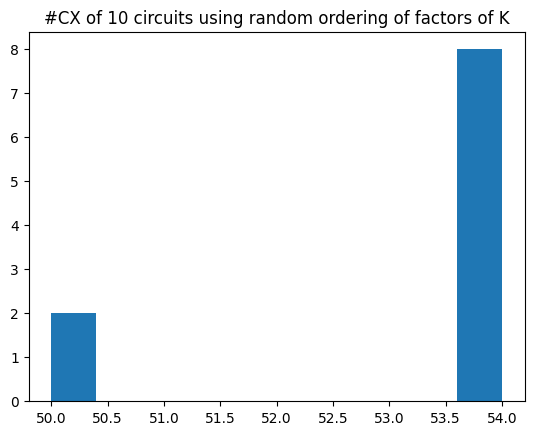

In [177]:
# Plot Histogram.
from matplotlib import pyplot as plt
plt.hist(num_cx_list)
plt.title(f"#CX of {size} circuits using random ordering of factors of K")

In [178]:
# Compare above distribution with a lexicographic ordering of factors of K.

# Specify Ham and corresponding undecomposed circuit.
test_heisenberg_ham = SparsePauliOp(["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"], 
                                    coeffs = np.ones(6, dtype=int))
test_paulievolutiongate = PauliEvolutionGate(test_heisenberg_ham, time=test_time_evolve)
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))

# Create HLS pass manager but with a -1 seed corresponding to lexicographic ordering.
hls_config_lexicographic = HLSConfig(PauliEvolution=[("cartan", {"random_seed":-1})])
pm_hls_lex = PassManager()
pm_hls_lex.append(HighLevelSynthesis(hls_config=hls_config_lexicographic))

# First PassManager. qc_before is the same input circuit as the previous cell.
qc_hls_lex = pm_hls_lex.run(qc_before) # HLS

# Second PassManager (the same as the previous cell), but the input is now qc_hls_lex.
# qc_l_lex = pm_other.layout.run(qc_hls_lex) # map virtual to physical
qc_r_lex = pm_other.routing.run(qc_hls_lex) # SABRE
qc_t_lex = pm_other.translation.run(qc_r_lex) # unroller
qc_o_lex = pm_other.optimization.run(qc_t_lex) # optimization

# Get #CX.
qc_o_lex.count_ops()['cx']

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
--- 0.1480398178100586 seconds ---
Optimization Error:
2.6437608884482626e-12


54

In [179]:
# Check that the transpiled circuit is close to the origina circuit by evaluating
# matrix norm of their difference.
from qiskit.quantum_info import Operator
qc_o_lex_unitarysim = transpile(qc_o_lex, unitary_simulator)
cartan_propagator_matrix = Operator(qc_o_lex).data

original_propagator_matrix_brute = scipy.linalg.expm(-1j*test_heisenberg_ham.to_matrix()*test_time_evolve)
display(np.linalg.norm(original_propagator_matrix_brute - cartan_propagator_matrix))

# Display the two matrices if needed.
from qiskit.visualization import array_to_latex
display(array_to_latex(original_propagator_matrix_brute))
display(array_to_latex(cartan_propagator_matrix))

6.415410082577599e-07

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### 3q NNN-open Heisenberg Ham on 4q branched backend

Same as before: generate many circuits, each corresponding to a random ordering of factors in K. Then feed each of the circuits above into a preset pass manager (the default pass managers used by the transpile() function) and get #CX gates. Then compare distribution of #CX with that resulting from a lexicographic ordering of factors in K.

We use the same Hamiltonian as above 
except append an identity for 0th qubit: IIXX, IXXI, ...
with coupling_map = [[0, 1], [0, 2], [0, 3], [1, 0], [2, 0], [3, 0]],
i.e qubit 0 is the central qubit with branches to each of the other qubits.

In [180]:
# Specify number of circuits to generate.
size = 50

# Specify Ham and corresponding undecomposed circuit.
test_heisenberg_ham = SparsePauliOp(["IXXI", "IYYI", "IZZI", "IIXX", "IIYY", "IIZZ"], 
                                    coeffs = np.ones(6, dtype=int))
test_paulievolutiongate = PauliEvolutionGate(test_heisenberg_ham, time=test_time_evolve)
qc_before = QuantumCircuit(4)
qc_before.append(test_paulievolutiongate, range(4))

# Create a PassManager objects containing the rest
# of the transpilation options.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import CouplingMap

pm_other = generate_preset_pass_manager(optimization_level=2, 
                                        layout_method="trivial",
                                        coupling_map=CouplingMap([[0, 1], [0, 2], [0, 3], [1, 0], [2, 0], [3, 0]]), 
                                        routing_method="sabre",
                                        translation_method="unroller",
                                        basis_gates="['u1', 'u2', 'u3', 'cx']",
                                        seed_transpiler=1)

# Generate transpiled circuits.
qc_list = []
different_seeds = random.sample(range(1, 101), size) # WLOG choose to generate random numbers between 1 and 100
for i in range(size):
    
    # Create a PassManager object containing just the custom HLS pass.
    hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":different_seeds[i]})])
    pm_hls = PassManager()
    pm_hls.append(HighLevelSynthesis(hls_config=hls_config))

    # First PassManager.
    qc_hls = pm_hls.run(qc_before) # HLS

    # Second PassManager.
    qc_l = pm_other.layout.run(qc_hls) # map virtual to physical
    qc_t = pm_other.translation.run(qc_l) # unroller
    qc_r = pm_other.routing.run(qc_t) # SABRE
    qc_o = pm_other.optimization.run(qc_r) # optimization

    qc_list.append(qc_o)

# Get CX distribution
num_cx_list = [qc.count_ops()['cx'] for qc in qc_list]
display(num_cx_list)

qc_o.draw()

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.586419
         Iterations: 27
         Function evaluations: 36
         Gradient evaluations: 36
--- 0.12468290328979492 seconds ---
Optimization Error:
2.0198010889869213e-11
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21
--- 0.06458759307861328 seconds ---
Optimization Error:
1.0930240125731814e-10
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 18
--- 0.06565666198730469 seconds ---
Optimization Error:
2.1805619683055987e-12
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.586419
         Iterations: 18

[63,
 57,
 57,
 63,
 63,
 63,
 57,
 57,
 59,
 63,
 57,
 57,
 57,
 63,
 63,
 63,
 61,
 63,
 61,
 57,
 57,
 57,
 57,
 61,
 63,
 57,
 59,
 57,
 57,
 61,
 63,
 57,
 57,
 53,
 59,
 53,
 63,
 57,
 57,
 63,
 61,
 59,
 63,
 57,
 57,
 61,
 57,
 53,
 59,
 53]

global phase: 1.2876
                          ┌───┐     ┌───┐                                    »
q_0: ──────────────────■──┤ X ├──■──┤ X ├──■───────────────────■─────────────»
                       │  └─┬─┘  │  └─┬─┘┌─┴─┐┌─────────────┐┌─┴─┐┌─────────┐»
q_1: ──────────────────┼────┼────┼────┼──┤ X ├┤ U1(0.47403) ├┤ X ├┤ U2(0,π) ├»
     ┌──────────────┐┌─┴─┐  │  ┌─┴─┐  │  └───┘└─────────────┘└───┘└─────────┘»
q_2: ┤ U(π/2,0,π/2) ├┤ X ├──■──┤ X ├──┼──────────────────────────────────────»
     └─┬─────────┬──┘└───┘     └───┘  │                                      »
q_3: ──┤ U2(0,π) ├────────────────────■──────────────────────────────────────»
       └─────────┘                                                           »
«     ┌───┐ ┌───────────────┐ ┌───┐                                     ┌───┐»
«q_0: ┤ X ├─┤ U(π/2,π/2,-π) ├─┤ X ├──■────────────────────■─────────────┤ X ├»
«     └─┬─┘ └───────────────┘ └─┬─┘┌─┴─┐┌──────────────┐┌─┴─┐┌─────────┐└─┬─┘»
«q_1: ──┼───────────────────────┼──┤ X ├┤ U1(-0.40885) ├┤ X ├┤ U2(0,π) ├──┼──»
«       │                       │  └───┘└──────────────┘└───┘└─────────┘  │  »
«q_2: ──┼───────────────────────┼─────────────────────────────────────────┼──»
«       │  ┌─────────────────┐  │                                         │  »
«q_3: ──■──┤ U(π/2,π/2,-π/2) ├──■─────────────────────────────────────────■──»
«          └─────────────────┘                                               »
«           ┌─────────┐      ┌───┐                                         »
«q_0: ──────┤ U2(0,π) ├──────┤ X ├──■───────────────────■──────────────────»
«           └─────────┘      └─┬─┘┌─┴─┐┌─────────────┐┌─┴─┐┌──────────────┐»
«q_1: ─────────────────────────┼──┤ X ├┤ U1(-2.3475) ├┤ X ├┤ U(π/2,0,π/2) ├»
«                              │  └───┘└─────────────┘└───┘└──────────────┘»
«q_2: ─────────────────────────┼───────────────────────────────────────────»
«     ┌─────────────────────┐  │                                           »
«q_3: ┤ U(0,1.9211,-1.9211) ├──■───────────────────────────────────────────»
«     └─────────────────────┘                                              »
«     ┌───┐┌─────────────────────┐┌───┐                        »
«q_0: ┤ X ├┤ U(0,1.9211,-1.9211) ├┤ X ├──■──────────────────■──»
«     └─┬─┘└─────────────────────┘└─┬─┘┌─┴─┐┌────────────┐┌─┴─┐»
«q_1: ──┼───────────────────────────┼──┤ X ├┤ U1(2.4611) ├┤ X ├»
«       │                           │  └───┘└────────────┘└───┘»
«q_2: ──┼───────────────────────────┼──────────────────────────»
«       │     ┌───────────────┐     │                          »
«q_3: ──■─────┤ U(π/2,π/2,-π) ├─────■──────────────────────────»
«             └───────────────┘                                »
«     ┌─────────────────┐                                              ┌───┐»
«q_0: ┤ U(π/2,π/2,-π/2) ├──■─────────────────────■─────────────────────┤ X ├»
«     ├─────────────────┤┌─┴─┐┌───────────────┐┌─┴─┐┌─────────────────┐└─┬─┘»
«q_1: ┤ U(π/2,-π/2,π/2) ├┤ X ├┤ U1(-0.012292) ├┤ X ├┤ U(π/2,π/2,-π/2) ├──┼──»
«     └─────────────────┘└───┘└───────────────┘└───┘└─────────────────┘  │  »
«q_2: ───────────────────────────────────────────────────────────────────┼──»
«                                                                        │  »
«q_3: ───────────────────────────────────────────────────────────────────■──»
«                                                                           »
«     ┌───────────────┐┌───┐                                           ┌───┐»
«q_0: ┤ U(π/2,π/2,-π) ├┤ X ├──■────────────────────■───────────────────┤ X ├»
«     └───────────────┘└─┬─┘┌─┴─┐┌──────────────┐┌─┴─┐┌───────────────┐└─┬─┘»
«q_1: ───────────────────┼──┤ X ├┤ U1(-0.95526) ├┤ X ├┤ U(π/2,π/2,-π) ├──┼──»
«                        │  └───┘└──────────────┘└───┘└───────────────┘  │  »
«q_2: ───────────────────┼───────────────────────────────────────────────┼──»
«        ┌─────────┐     │                                               │  »
«q_3: ───┤ U2(0,π) ├─────■─────

Text(0.5, 1.0, '#CX of 50 circuits using random ordering of factors of K')

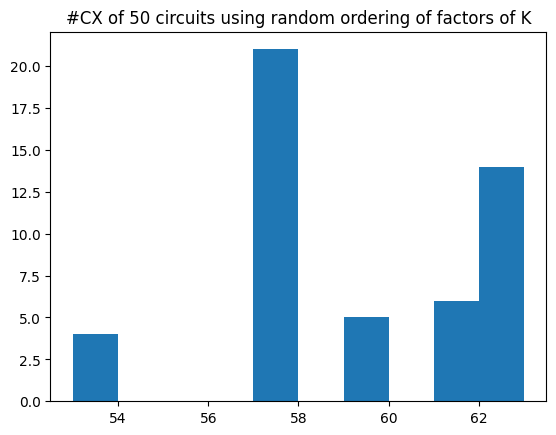

In [181]:
# Plot Histogram.
from matplotlib import pyplot as plt
plt.hist(num_cx_list)
plt.title(f"#CX of {size} circuits using random ordering of factors of K")

In [182]:
# Create a PassManager object containing just the custom HLS pass.
hls_config_lexicographic = HLSConfig(PauliEvolution=[("cartan", {"random_seed":-1})]) # lexicographic
pm_hls_lex = PassManager()
pm_hls_lex.append(HighLevelSynthesis(hls_config=hls_config_lexicographic))

# First PassManager.
qc_hls_lex = pm_hls_lex.run(qc_before) # HLS

# Second PassManager.
qc_l_lex = pm_other.layout.run(qc_hls_lex) # map virtual to physical
qc_t_lex = pm_other.translation.run(qc_l_lex) # unroller
qc_r_lex = pm_other.routing.run(qc_t_lex) # SABRE
qc_o_lex = pm_other.optimization.run(qc_r_lex) # optimization

# Get #CX.
qc_o_lex.count_ops()['cx']

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
--- 0.11313247680664062 seconds ---
Optimization Error:
2.6437608884482626e-12


57

#### ask nick about the below as well as putting routing before translation (or need two translation stages)

In [183]:
# CODE TO PLAY AROUND 

# If equiv() only returning TRUE for too high rtol/atol, calculate matrix norms between
# the original and transpiled circuits to see what is going on.

# Specify Ham and corresponding undecomposed circuit.
test_heisenberg_ham = SparsePauliOp(["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"], 
                                    coeffs = np.ones(6, dtype=int))
test_paulievolutiongate = PauliEvolutionGate(test_heisenberg_ham, time=test_time_evolve)
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))

from qiskit import Aer, transpile
unitary_simulator = Aer.get_backend('unitary_simulator')

qc_before_sim = transpile(qc_before, unitary_simulator)
# inspect intermediate stages
original_propagator_matrix = unitary_simulator.run(qc_before_sim).result().get_unitary().to_matrix()

original_propagator_matrix_brute = scipy.linalg.expm(-1j*test_heisenberg_ham.to_matrix()*test_time_evolve)

np.linalg.norm(original_propagator_matrix - original_propagator_matrix_brute)

from qiskit.visualization import array_to_latex
display(array_to_latex(original_propagator_matrix))
display(array_to_latex(original_propagator_matrix_brute))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [184]:
# np.trace(original_propagator_matrix.transpose().conjugate() @ original_propagator_matrix_brute) 

# original_propagator_matrix = Operator(qc_before).to_matrix()
# cartan_propagator_matrix = Operator(qc_hls_lex).to_matrix()

# np.trace(original_propagator_matrix.transpose().conjugate() @ original_propagator_matrix) / 2**3

# The matrix norms are close but not super close.
# In fact, we find the issue by in the 3rd

# qc_hls_lex.draw()
# qc_before_sim.draw()

# type(original_propagator_matrix)